# Mechanism of Action (MoA) Exploratory Data Analysis

- ```train_features.csv``` - Features for the training set. Features ```g-``` signify gene expression data, and ```c-``` signify cell viability data. ```cp_type``` indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; ```cp_time``` and ```cp_dose``` indicate treatment duration (24, 48, 72 hours) and dose (high or low).

- ```train_targets_scored.csv``` - The binary MoA targets that are scored.

- ```train_targets_nonscored.csv``` - Additional (optional) binary MoA responses for the training data. These are not predicted nor scored.

- ```test_features.csv``` - Features for the test data. You must predict the probability of each scored MoA for each row in the test data.

- ```sample_submission.csv``` - A submission file in the correct format.

In [1]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Deep learning libraries
import tensorflow as tf
from keras import Model
from keras.models import Sequential, load_model
from keras.layers import Dense, BatchNormalization, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Utility functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler

%matplotlib inline

Using TensorFlow backend.


In [2]:
train_feat_df = pd.read_csv('./train_features.csv')
test_feat_df = pd.read_csv('./test_features.csv')

scored_train_targets_df = pd.read_csv('./train_targets_scored.csv')
nscored_train_targets_df = pd.read_csv('./train_targets_nonscored.csv')

submission_sample_df = pd.read_csv('./sample_submission.csv')

In [3]:
train_feat_df.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [4]:
scored_train_targets_df.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
nscored_train_targets_df.head()

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# EDA

## Training features

In [6]:
sb.set_style('darkgrid')               # darkgrid, whitegrid, dark, white, ticks
pal_s_d = sb.cubehelix_palette(3, rot=-.25, light=.4)
pal_l_d = sb.cubehelix_palette(20, rot=-.25, light=.4)
pal_s_c = sb.cubehelix_palette(3, rot=-.25, light=.8)
pal_l_c = sb.cubehelix_palette(20, rot=-.25, light=.8)

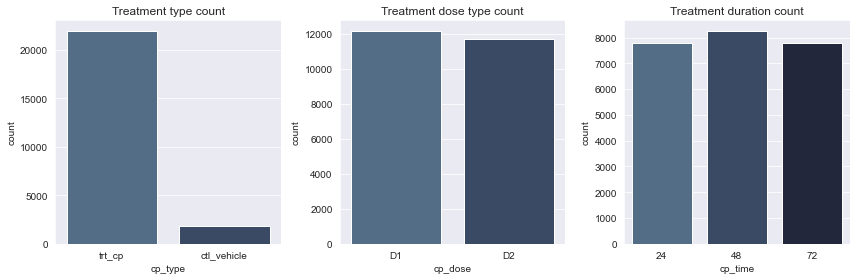

In [7]:
cp_type_count = train_feat_df.cp_type.value_counts().reset_index().rename(columns={'index':'cp_type','cp_type':'count'})
cp_dose_count = train_feat_df.cp_dose.value_counts().reset_index().rename(columns={'index':'cp_dose','cp_dose':'count'})
cp_time_count = train_feat_df.cp_time.value_counts().reset_index().rename(columns={'index':'cp_time','cp_time':'count'})

plt.figure(figsize=(12,4))
plt.subplot(131)
sb.barplot(data=cp_type_count, x='cp_type', y='count', palette=pal_s_d)
plt.title('Treatment type count')
plt.subplot(132)
sb.barplot(data=cp_dose_count, x='cp_dose', y='count', palette=pal_s_d)
plt.title('Treatment dose type count')
plt.subplot(133)
sb.barplot(data=cp_time_count, x='cp_time', y='count', palette=pal_s_d)
plt.title('Treatment duration count')
plt.tight_layout()

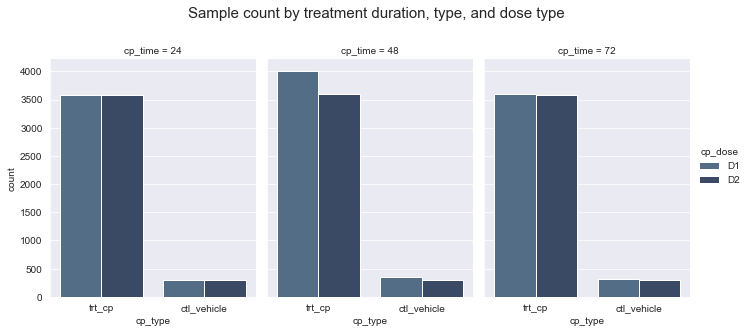

In [8]:
g = sb.catplot(data=train_feat_df, x='cp_type',hue='cp_dose', col='cp_time', kind="count",
               height=4, aspect=.8, palette=pal_s_d)
g.fig.suptitle('Sample count by treatment duration, type, and dose type', fontsize=15, y=1.1);

### Gene expression data

In [9]:
gene_cols = train_feat_df.columns[4:-100]
gene_data = train_feat_df[gene_cols]

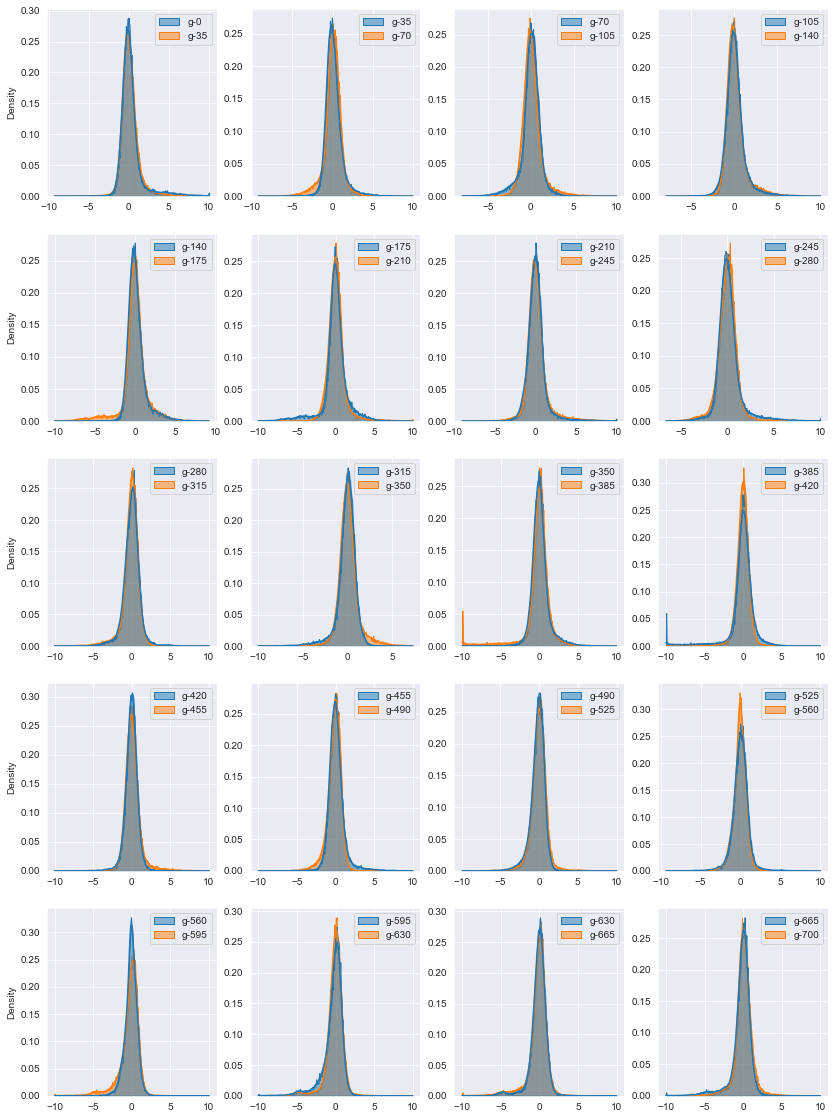

In [10]:
plt.figure(figsize=(14,20))
m=5; n=4; k=0
for i in range(n*m):
    plt.subplot(m,n,i+1)
    sb.histplot(gene_data.iloc[:,[k,k+35]], stat="density", element='poly', kde=True )
    if (i%4) != 0:
        plt.ylabel('')
    k+=35

In [11]:
gene_desc = gene_data.describe()
display(gene_desc)

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,0.119905,...,0.207299,0.009161,0.171027,0.002316,-0.209799,-0.076251,0.134162,-0.128018,-0.219210,0.101524
std,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,1.087180,...,1.096488,1.200395,1.357701,1.052771,1.201918,1.115477,0.951264,1.230636,1.326193,1.417674
min,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,-8.337000,...,-8.193000,-10.000000,-9.795000,-8.180000,-10.000000,-10.000000,-4.269000,-10.000000,-10.000000,-10.000000
25%,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,-0.360200,...,-0.433875,-0.502250,-0.537075,-0.508775,-0.606175,-0.506200,-0.353100,-0.544600,-0.554400,-0.523800
50%,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,0.160450,...,0.059600,-0.005900,-0.013600,-0.027700,-0.011850,0.009900,0.005400,0.000600,0.028700,-0.006500
75%,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,0.697775,...,0.648500,0.492150,0.522500,0.457000,0.483000,0.511175,0.409075,0.498500,0.496400,0.536950
max,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,6.433000,...,10.000000,9.552000,10.000000,8.346000,5.444000,6.317000,10.000000,5.911000,10.000000,10.000000


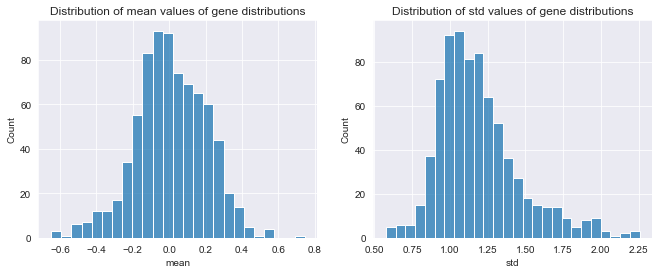

In [12]:
plt.figure(figsize=(11,4))
plt.subplot(121)
sb.histplot(gene_desc.loc['mean',:])
plt.title('Distribution of mean values of gene distributions')
plt.subplot(122)
sb.histplot(gene_desc.loc['std',:])
plt.title('Distribution of std values of gene distributions');

Gene with lowest distribution mean


,count,mean,std,min,25%,50%,75%,max
g-370,23814.0,-0.648438,1.580592,-10.0,-0.8377,0.0,0.067375,3.247


Gene with highest distribution mean


,count,mean,std,min,25%,50%,75%,max
g-707,23814.0,0.7447,1.457132,-1.672,0.0,0.0,1.004,10.0


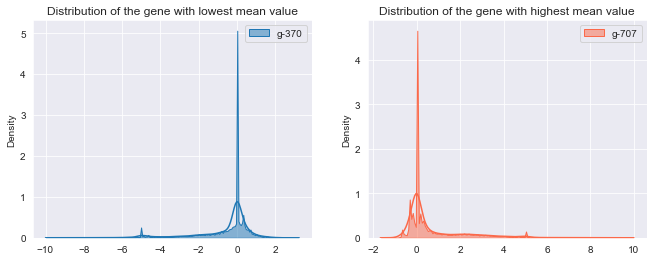

In [13]:
min_mean = min(gene_desc.loc['mean',:])
max_mean = max(gene_desc.loc['mean',:])

lowest_mean_gene = gene_desc.T.query("mean==@min_mean")
print("Gene with lowest distribution mean")
display(lowest_mean_gene)
highest_mean_gene = gene_desc.T.query("mean==@max_mean")
print("Gene with highest distribution mean")
display(highest_mean_gene)

plt.figure(figsize=(11,4))
plt.subplot(121)
sb.histplot(gene_data.iloc[:,[370]], stat="density", element='poly', kde=True )
plt.title("Distribution of the gene with lowest mean value")
plt.subplot(122)
sb.histplot(gene_data.iloc[:,[707]], stat="density", element='poly', kde=True, palette='Reds' )
plt.title("Distribution of the gene with highest mean value");

### Cell viability data

In [14]:
cell_via_cols = train_feat_df.columns[-100:]
cell_via_data = train_feat_df[cell_via_cols]

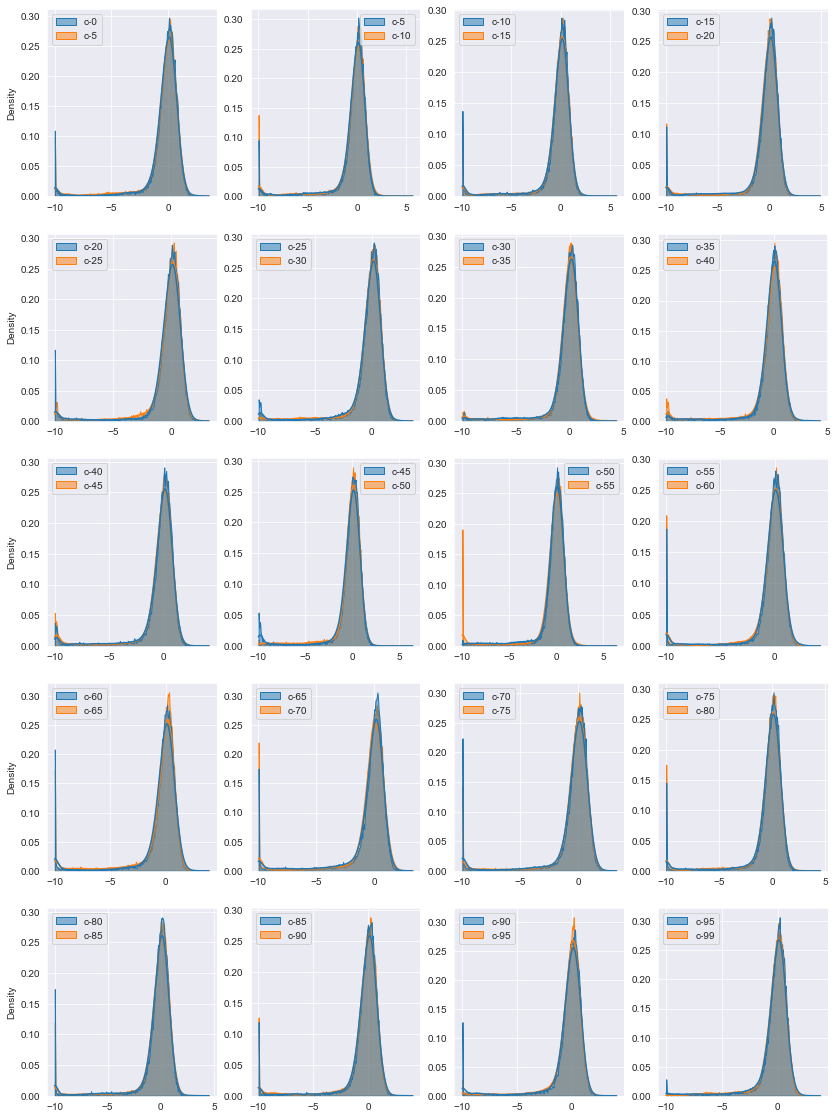

In [15]:
plt.figure(figsize=(14,20))
m=5; n=4; k=0
for i in range(n*m):
    plt.subplot(m,n,i+1)
    sb.histplot(cell_via_data.iloc[:,[k,min(k+5,99)]], stat="density", element='poly', kde=True)
    if (i%4) != 0:
        plt.ylabel('')
    k+=5

In [16]:
cell_desc = cell_via_data.describe()
display(cell_desc)

,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,-0.355156,-0.455359,-0.480542,-0.377666,-0.493552,-0.446037,-0.574855,-0.266293,-0.451307,-0.458664,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,1.752565,2.004962,2.039346,1.554583,2.091888,1.893484,2.234152,1.465313,1.948829,1.646122,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,-0.549300,-0.538425,-0.550375,-0.601975,-0.559975,-0.578775,-0.571250,-0.524275,-0.551100,-0.654675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,-0.009000,0.009800,-0.004000,-0.039050,0.011400,-0.008900,0.007400,0.006350,-0.005350,-0.025350,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,0.448975,0.476875,0.460575,0.413100,0.470300,0.442675,0.459475,0.469375,0.453175,0.424400,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,3.365000,3.915000,2.970000,2.408000,4.555000,3.614000,3.904000,4.918000,3.648000,3.194000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


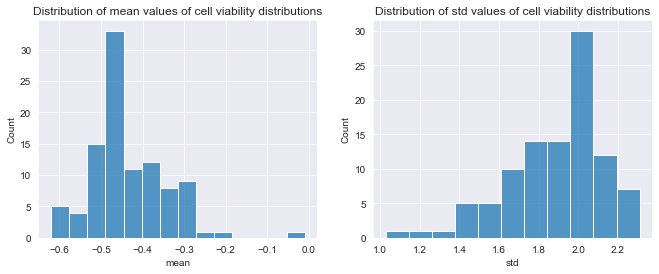

In [17]:
plt.figure(figsize=(11,4))
plt.subplot(121)
sb.histplot(cell_desc.loc['mean',:])
plt.title('Distribution of mean values of cell viability distributions')
plt.subplot(122)
sb.histplot(cell_desc.loc['std',:])
plt.title('Distribution of std values of cell viability distributions');

Cell with lowest distribution mean


,count,mean,std,min,25%,50%,75%,max
c-65,23814.0,-0.619682,2.225596,-10.0,-0.6032,0.00765,0.44125,3.328


Cell with highest distribution mean


,count,mean,std,min,25%,50%,75%,max
c-74,23814.0,-0.010404,1.02982,-6.452,-0.389925,0.08155,0.563575,3.17


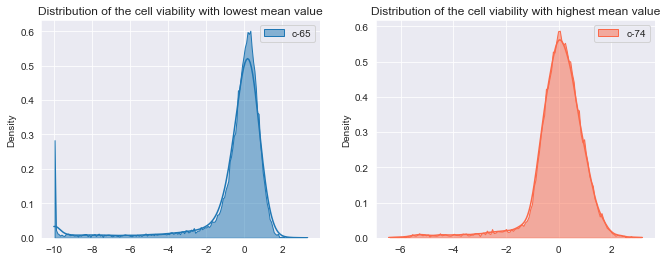

In [18]:
min_mean = min(cell_desc.loc['mean',:])
max_mean = max(cell_desc.loc['mean',:])

lowest_mean_cell = cell_desc.T.query("mean==@min_mean")
print("Cell with lowest distribution mean")
display(lowest_mean_cell)
highest_mean_cell = cell_desc.T.query("mean==@max_mean")
print("Cell with highest distribution mean")
display(highest_mean_cell)

plt.figure(figsize=(11,4))
plt.subplot(121)
sb.histplot(cell_via_data.iloc[:,[65]], stat="density", element='poly', kde=True )
plt.title("Distribution of the cell viability with lowest mean value")
plt.subplot(122)
sb.histplot(cell_via_data.iloc[:,[74]], stat="density", element='poly', kde=True, palette='Reds' )
plt.title("Distribution of the cell viability with highest mean value");

## Scored training targets

In [19]:
scored_train_targets_df.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
i=0
target_values = pd.DataFrame({'index':[0,1]})
for col in scored_train_targets_df.columns:
    temp = scored_train_targets_df[str(col)].value_counts().reset_index()
    if i>0:
        target_values = target_values.merge(temp, how='left', on='index')
    i+=1
target_values.set_index('index', inplace=True)

In [21]:
target_values = target_values.T.reset_index().rename(columns={'index':'MoA'})
target_values

index,MoA,0,1
0,5-alpha_reductase_inhibitor,23797,17
1,11-beta-hsd1_inhibitor,23796,18
2,acat_inhibitor,23790,24
3,acetylcholine_receptor_agonist,23624,190
4,acetylcholine_receptor_antagonist,23513,301
...,...,...,...
201,ubiquitin_specific_protease_inhibitor,23808,6
202,vegfr_inhibitor,23644,170
203,vitamin_b,23788,26
204,vitamin_d_receptor_agonist,23775,39


In [22]:
target_values.describe()

index,0,1
count,206.000000,206.000000
mean,23732.233010,81.766990
std,115.160351,115.160351
min,22982.000000,1.000000
25%,23731.000000,19.000000
50%,23775.500000,38.500000
75%,23795.000000,83.000000
max,23813.000000,832.000000


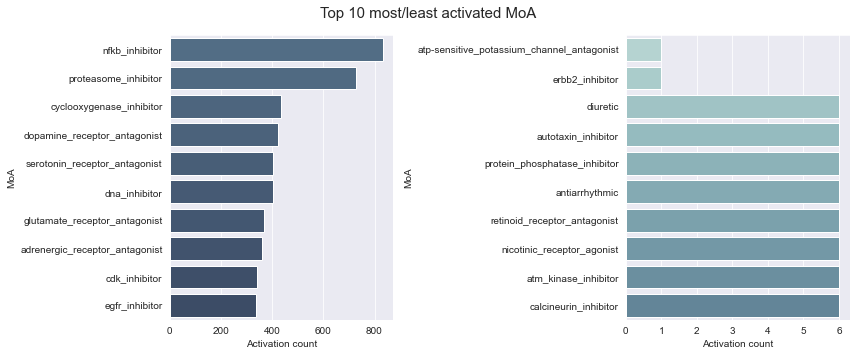

In [23]:
most_active = target_values.sort_values(by=[1], ascending=False)
most_active = most_active.set_index('MoA').iloc[0:10,1].reset_index()

least_active = target_values.sort_values(by=[1])
least_active = least_active.set_index('MoA').iloc[0:10,1].reset_index()

plt.figure(figsize=(12,5))
plt.suptitle('Top 10 most/least activated MoA',fontsize=15)
ax1 = plt.subplot(121)
sb.barplot(y='MoA', x='Activation count', data=most_active.rename(columns={1:'Activation count'}), palette=pal_l_d, ax=ax1)
ax2 = plt.subplot(122)
sb.barplot(y='MoA', x='Activation count', data=least_active.rename(columns={1:'Activation count'}), palette=pal_l_c, ax=ax2)
plt.tight_layout()

In [24]:
master_df = train_feat_df.copy()
master_df = master_df.merge(scored_train_targets_df, how='left', on='sig_id')

In [25]:
master_df.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0,0,0,0,0,0,0,0,0,0


In [26]:
target_names = list(master_df.columns[-206:])

sample_activation_state = (master_df[target_names]!=0).any(axis=1)
sample_activation_count = (master_df[target_names]!=0).sum(axis=1)
top_10_most_act_samples = sample_activation_count.sort_values(ascending=False)
top_10_most_act_samples = pd.concat([master_df.iloc[top_10_most_act_samples.index[0:10], 0], top_10_most_act_samples[0:10]],
                                    axis=1)

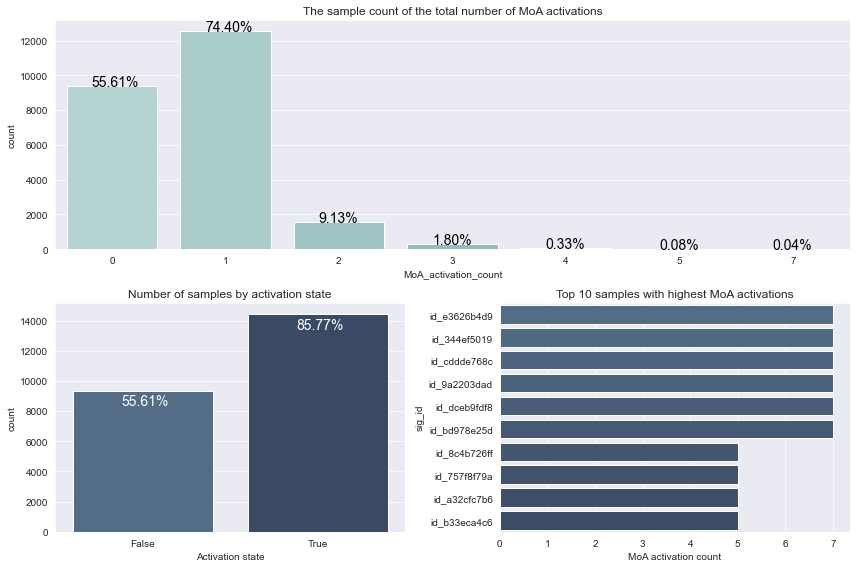

In [27]:
plt.figure(figsize=(12,8))
plt.subplot(211)
ax1 = sb.countplot(data=sample_activation_count.rename('MoA_activation_count').reset_index(),
             x='MoA_activation_count', palette=pal_l_c)
for p in ax1.patches:
    percentage ='{:.2f}%'.format(p.get_height()*100/16844)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width/3.6
    y=p.get_y()+height
    ax1.annotate(percentage,(x,y), fontsize=14, color='black')
plt.title('The sample count of the total number of MoA activations')
plt.subplot(223)
ax2 = sb.countplot(data=sample_activation_state.reset_index().rename(columns={0:'Activation state'}),
             x='Activation state', palette=pal_s_d)
for p in ax2.patches:
    percentage ='{:.2f}%'.format(p.get_height()*100/16844)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width/2.9
    y=p.get_y()+height-1000
    ax2.annotate(percentage,(x,y), fontsize=14, color='white')
plt.title('Number of samples by activation state')
plt.subplot(224)
sb.barplot(data=top_10_most_act_samples.rename(columns={0:'MoA activation count'}),
             x='MoA activation count', y='sig_id', palette=pal_l_d, estimator=sum)
plt.title('Top 10 samples with highest MoA activations')
plt.tight_layout()

**Activation by treatment features**

In [28]:
master_df = master_df.merge(sample_activation_count.rename('MoA_activation_count'), how='left',
                            left_index=True, right_index=True)

In [29]:
basic_feat = master_df.loc[:,['sig_id', 'cp_type', 'cp_dose', 'cp_time', 'MoA_activation_count']]
display(basic_feat)

,sig_id,cp_type,cp_dose,cp_time,MoA_activation_count
0,id_000644bb2,trt_cp,D1,24,1
1,id_000779bfc,trt_cp,D1,72,0
2,id_000a6266a,trt_cp,D1,48,3
3,id_0015fd391,trt_cp,D1,48,0
4,id_001626bd3,trt_cp,D2,72,1
...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,D2,24,1
23810,id_fffb70c0c,trt_cp,D2,24,1
23811,id_fffc1c3f4,ctl_vehicle,D2,48,0
23812,id_fffcb9e7c,trt_cp,D1,24,1


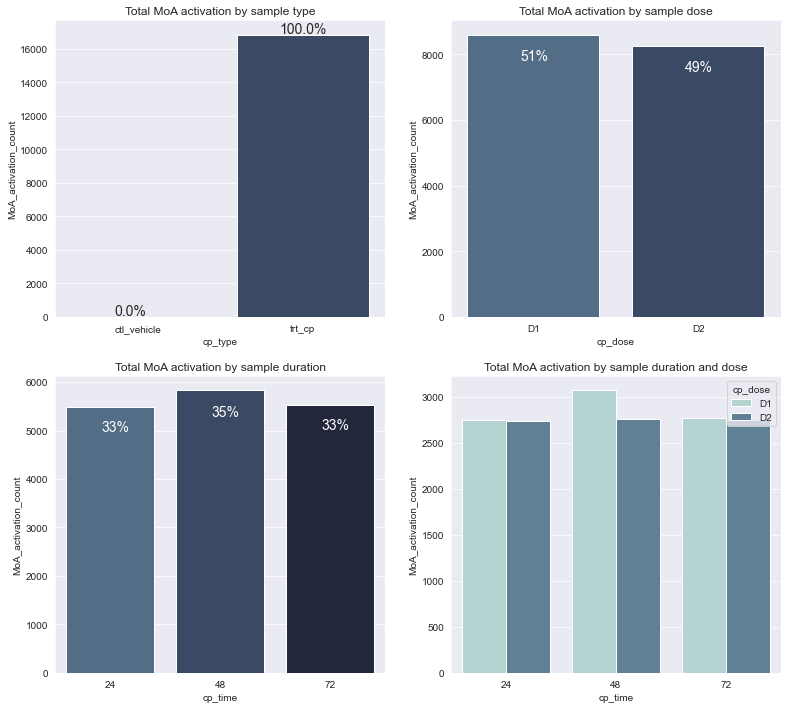

In [30]:
plt.figure(figsize=(13,12))

plt.subplot(221)
ax = sb.barplot(data=basic_feat.groupby('cp_type').sum()['MoA_activation_count'].reset_index(),
                x='cp_type', y='MoA_activation_count', palette=pal_s_d)
for p in ax.patches:
    percentage ='{:}%'.format(p.get_height()*100/16844)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width-0.54
    y=p.get_y()+height+100
    ax.annotate(percentage,(x,y), fontsize=14)
plt.title('Total MoA activation by sample type')

plt.subplot(222)
ax2 = sb.barplot(data=basic_feat.groupby('cp_dose').sum()['MoA_activation_count'].reset_index(),
                x='cp_dose', y='MoA_activation_count', palette=pal_s_d)
for p in ax2.patches:
    percentage ='{:.0f}%'.format(p.get_height()*100/16844)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width/2.5
    y=p.get_y()+height/1.1
    ax2.annotate(percentage,(x,y), fontsize=14, color='white')
plt.title('Total MoA activation by sample dose')
    
plt.subplot(223)
ax3 = sb.barplot(data=basic_feat.groupby('cp_time').sum()['MoA_activation_count'].reset_index(),
                x='cp_time', y='MoA_activation_count', palette=pal_s_d)
for p in ax3.patches:
    percentage ='{:.0f}%'.format(p.get_height()*100/16844)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width/2.5
    y=p.get_y()+height/1.1
    ax3.annotate(percentage,(x,y), fontsize=14, color='white')
plt.title('Total MoA activation by sample duration')

plt.subplot(224)
ax3 = sb.barplot(data=basic_feat, x='cp_time', y='MoA_activation_count', hue='cp_dose',ci=None, estimator=sum, palette=pal_s_c)
plt.title('Total MoA activation by sample duration and dose');

## PCA gene features

In [31]:
gene_data

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,...,-0.5055,-0.3167,1.0930,0.0084,0.8611,-0.5582,0.3008,1.6490,0.2968,-0.0224
1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,...,-0.5338,0.0224,-0.4831,0.2128,-0.6999,-0.1214,-0.1626,-0.3340,-0.3289,-0.2718
2,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,...,2.5770,0.2356,1.3230,-1.3730,-0.2682,0.8427,0.5797,0.3143,0.8133,0.7923
3,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,...,-0.1292,3.4310,1.2720,-0.4733,-2.0560,0.5699,0.1996,0.4374,0.1588,-0.0343
4,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,...,-0.6904,2.0540,-0.3131,-0.0809,0.3910,1.7660,-1.0020,-0.7534,0.5000,-0.6269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,...,0.7790,0.5393,0.4112,-0.5059,0.0240,-0.2297,0.7221,0.5099,-0.1423,0.3806
23810,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,0.5112,0.6727,...,-0.0858,0.3606,-0.0248,0.0672,-0.5901,-0.1022,0.5247,0.5438,-0.1875,-0.4751
23811,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,-0.2541,0.1745,-0.0340,0.4865,...,0.1796,0.3488,0.0927,0.5166,-0.3099,-0.5946,0.9778,0.2326,-0.6191,0.3603
23812,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,0.0463,0.4299,-0.7985,...,-0.1410,1.9590,0.8224,1.2500,-3.1930,-2.8720,0.1794,0.3109,-0.3491,-0.4741


In [32]:
scaled_gene_data = scale(gene_data)

In [33]:
pca1 = PCA(.95)
pca1.fit(scaled_gene_data)

PCA(n_components=0.95)

In [34]:
pca_gene = pca1.transform(scaled_gene_data)
per_var = np.round(pca1.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

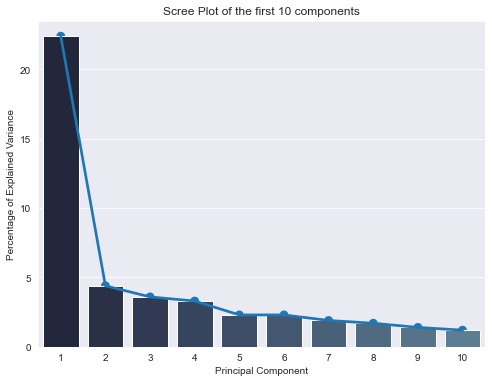

In [35]:
plt.figure(figsize=(8,6))
sb.pointplot(x=list(range(1,11)), y=per_var[0:10])
sb.barplot(x=list(range(1,11)), y=per_var[0:10], tick_label=labels[0:10], palette=reversed(pal_l_c), )
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot of the first 10 components');

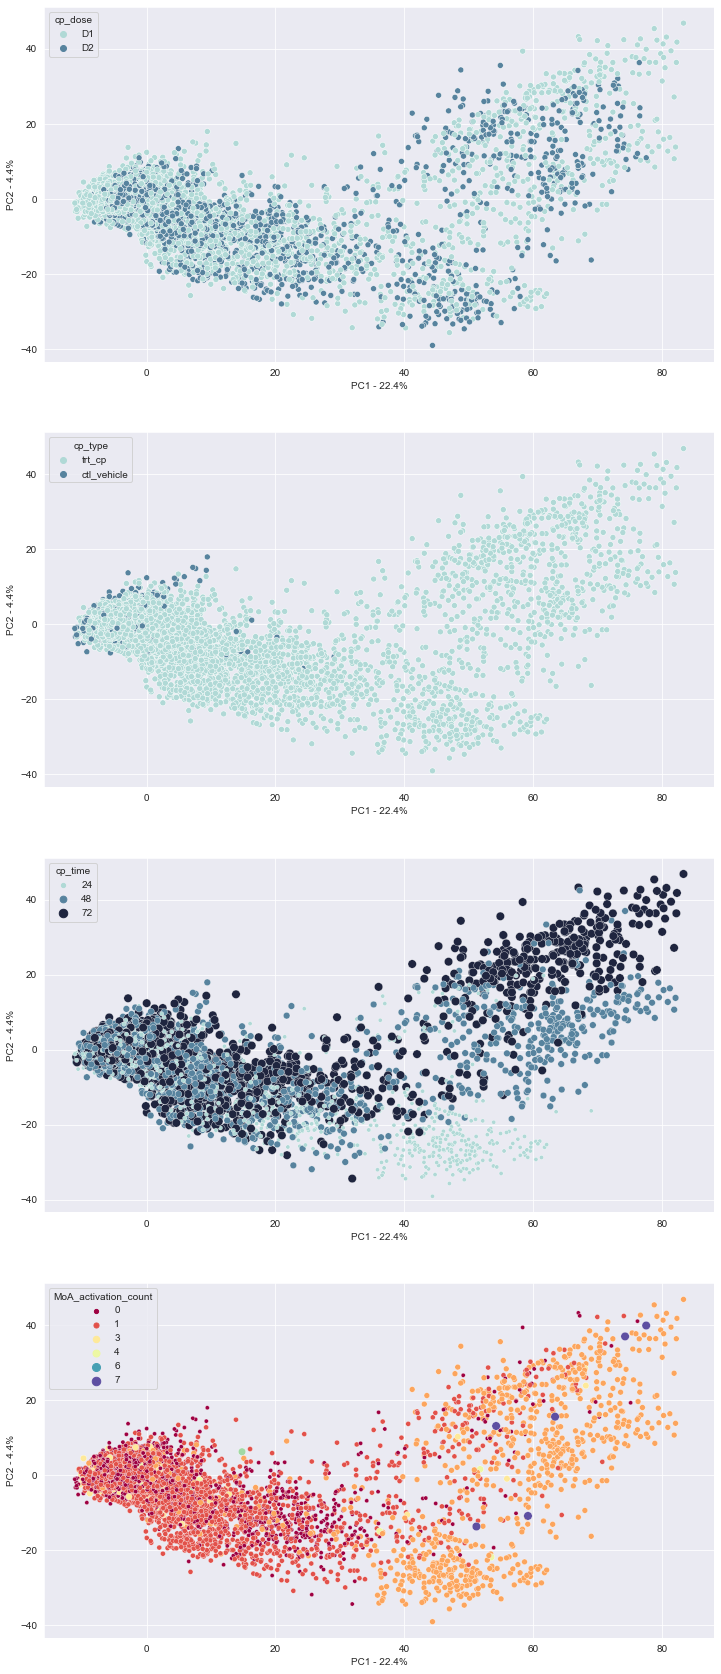

In [36]:
transformed_gene_feats = pd.DataFrame(pca_gene, columns=labels)
gene_temp = basic_feat.merge(transformed_gene_feats, how='left', left_index=True, right_index=True)
plt.figure(figsize=(12,30))
plt.subplot(411)
sb.scatterplot(data=gene_temp, x='PC1', y='PC2', hue='cp_dose', palette=pal_s_c[0:2])
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.subplot(412)
sb.scatterplot(data=gene_temp, x='PC1', y='PC2', hue='cp_type', palette=pal_s_c[0:2])
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.subplot(413)
sb.scatterplot(data=gene_temp, x='PC1', y='PC2', hue='cp_time', size='cp_time', palette=pal_s_c[0:3])
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.subplot(414)
sb.scatterplot(data=gene_temp, x='PC1', y='PC2', hue='MoA_activation_count', size='MoA_activation_count',palette="Spectral")
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]));

In [37]:
# 3d visualization of the genes by cp_dose, cp_type, and cp_time in the new space 
# generated by the first 3 principal components

#px.scatter_3d(gene_temp, x='PC1', y='PC2', z='PC3', color='cp_dose' ,opacity=0.2)
#px.scatter_3d(gene_temp, x='PC1', y='PC2', z='PC3', color='cp_type' ,opacity=0.2)
#px.scatter_3d(gene_temp, x='PC1', y='PC2', z='PC3', color='cp_time' ,opacity=0.2)

## PCA cell features

In [38]:
cell_via_data

,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,-0.0600,0.1083,0.6864,0.4043,0.4213,-0.6797,0.2888,0.4323,-0.3381,0.3407,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,0.0927,0.2723,0.2772,0.7776,0.3679,0.5696,0.2835,1.4080,0.3745,0.6775,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,-0.1312,-1.4640,0.3394,-1.7790,0.2188,0.5826,-0.7513,0.0543,0.7182,-0.4159,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,-0.3998,-4.5520,-2.7350,-1.9630,-2.8610,-1.2670,-2.5830,-0.5036,-3.1590,-1.8510,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,-0.3774,0.7364,-0.1659,0.2341,1.0060,0.3204,-0.0852,-0.2284,-0.2533,-0.3174,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,0.4224,0.1871,-0.4822,0.3713,0.4754,0.9512,0.4650,0.3005,0.0338,-0.7734,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,0.2144,0.4350,0.1174,1.3960,-0.6772,0.2316,-0.5396,0.0581,0.6067,-0.4622,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,1.0650,0.6329,0.3742,0.1237,0.6147,0.4589,-0.2372,1.1160,0.4623,0.2830,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,0.5377,1.3240,0.9679,0.1419,1.2230,0.3404,-0.1589,0.8667,0.7749,-0.1458,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


In [39]:
scaled_cell_data = scale(cell_via_data)

In [40]:
pca2 = PCA(.95)
pca2.fit(scaled_cell_data)

PCA(n_components=0.95)

In [41]:
pca_cell = pca2.transform(scaled_cell_data)
per_var = np.round(pca2.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

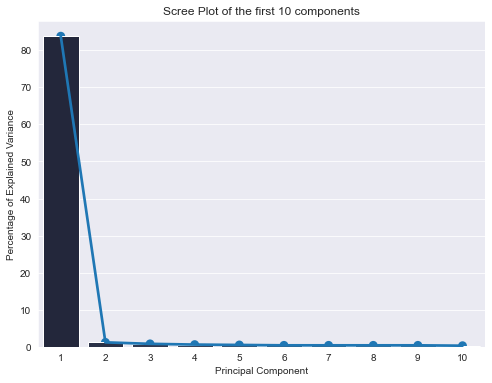

In [42]:
plt.figure(figsize=(8,6))
sb.pointplot(x=list(range(1,11)), y=per_var[0:10])
sb.barplot(x=list(range(1,11)), y=per_var[0:10], tick_label=labels[0:10], palette=reversed(pal_l_c))
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot of the first 10 components');

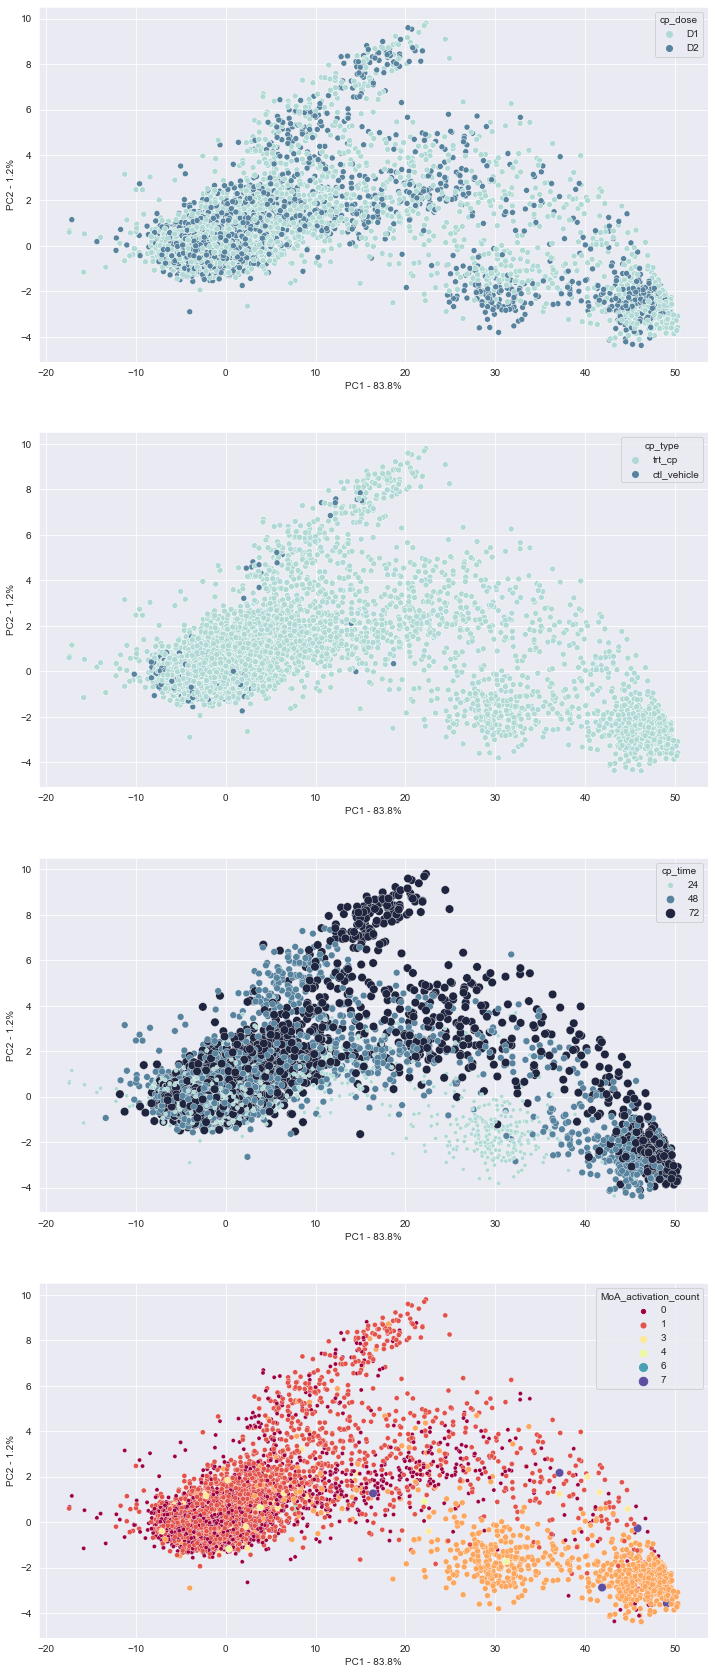

In [43]:
transformed_cell_feats = pd.DataFrame(pca_cell, columns=labels)
gene_temp = basic_feat.merge(transformed_cell_feats, how='left', left_index=True, right_index=True)
plt.figure(figsize=(12,30))
plt.subplot(411)
sb.scatterplot(data=gene_temp, x='PC1', y='PC2', hue='cp_dose', palette=pal_s_c[0:2])
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.subplot(412)
sb.scatterplot(data=gene_temp, x='PC1', y='PC2', hue='cp_type', palette=pal_s_c[0:2])
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.subplot(413)
sb.scatterplot(data=gene_temp, x='PC1', y='PC2', hue='cp_time', size='cp_time', palette=pal_s_c[0:3])
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
plt.subplot(414)
sb.scatterplot(data=gene_temp, x='PC1', y='PC2', hue='MoA_activation_count', size='MoA_activation_count',palette="Spectral")
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]));

# NN Model

In [44]:
Train_data = train_feat_df.drop(columns=['sig_id']+list(gene_cols)+list(cell_via_cols) )

In [45]:
Train_data = Train_data.merge(transformed_gene_feats, how='left', left_index=True, right_index=True)
Train_data = Train_data.merge(transformed_cell_feats, how='left', left_index=True, right_index=True)
Train_data[['ctl_vehicle','trt_cp']] = pd.get_dummies(Train_data.cp_type)
Train_data[['D1','D2']] = pd.get_dummies(Train_data.cp_dose)
Train_data.drop(columns=['cp_type','cp_dose'], inplace=True)

In [46]:
Train_data

,cp_time,PC1_x,PC2_x,PC3_x,PC4_x,PC5_x,PC6_x,PC7_x,PC8_x,PC9_x,...,PC39_y,PC40_y,PC41_y,PC42_y,PC43_y,PC44_y,ctl_vehicle,trt_cp,D1,D2
0,24,-5.979264,-1.550012,-0.502657,7.610341,2.050595,-5.608992,0.569159,3.113275,-2.178552,...,-0.375722,-0.399708,0.173218,-0.228173,0.200874,-0.577410,0,1,1,0
1,72,-4.980401,3.846588,7.405576,-4.088724,-1.163923,4.233157,1.971495,1.358631,0.273302,...,0.090697,0.225336,0.149173,-0.081529,0.010348,-0.003237,0,1,1,0
2,48,-1.277123,2.626640,-3.098642,-5.160985,-0.862044,-0.332660,2.230737,-2.632508,-0.090752,...,0.146410,-0.544878,-0.404767,-0.498045,-0.392224,0.376208,0,1,1,0
3,48,6.386498,-2.626036,-5.265179,-8.992739,0.707729,-6.287851,2.813483,-6.799060,-0.356779,...,0.999233,-0.441580,-0.912765,0.227396,0.394693,-0.758166,0,1,1,0
4,72,-5.556092,0.921688,4.123502,-8.539803,1.471287,-3.358239,-1.307632,-0.794091,7.106465,...,-0.096882,0.124499,-0.302622,0.033826,0.235381,-0.030390,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,24,-4.050846,2.455376,-1.952724,-2.745738,-0.230533,-0.046272,0.977865,-0.534667,-2.717050,...,0.065140,-0.487499,0.087183,-0.699742,0.292847,-0.161913,0,1,0,1
23810,24,-3.587688,-0.719366,-2.095710,1.556405,3.480427,0.490399,-0.826361,-1.985018,1.169461,...,0.025380,0.519035,0.436159,0.291935,-0.115566,0.352483,0,1,0,1
23811,48,-4.575507,-1.040907,-0.129310,0.465662,-1.097595,-1.519675,2.197309,0.772037,0.941187,...,0.257997,-0.060514,-0.117519,-0.003575,0.241918,-0.365624,1,0,0,1
23812,24,3.805914,-16.156608,5.855234,7.802877,-6.736117,-1.319509,0.969848,6.297461,-6.666178,...,-0.149151,-0.474675,0.504370,-0.280015,0.513463,0.564199,0,1,1,0


In [47]:
scaler = StandardScaler()
scaler.fit(Train_data)

StandardScaler()

In [48]:
Train_data_scaled = pd.DataFrame(scaler.transform(Train_data))

In [49]:
Train_data_scaled

,0,1,2,3,4,5,6,7,8,9,...,560,561,562,563,564,565,566,567,568,569
0,-1.237999,-0.454727,-0.266090,-0.095055,1.512799,0.482955,-1.342296,0.147553,0.854344,-0.660847,...,-1.008202,-1.079272,0.470095,-0.621003,0.551545,-1.599250,-0.291580,0.291580,0.980043,-0.980043
1,1.235922,-0.378763,0.660343,1.400438,-0.812765,-0.274127,1.013043,0.511104,0.372835,0.082904,...,0.243374,0.608441,0.404839,-0.221894,0.028412,-0.008966,-0.291580,0.291580,0.980043,-0.980043
2,-0.001039,-0.097126,0.450915,-0.585971,-1.025911,-0.203028,-0.079609,0.578312,-0.722412,-0.027529,...,0.392872,-1.471251,-1.098493,-1.355498,-1.076936,1.041981,-0.291580,0.291580,0.980043,-0.980043
3,-0.001039,0.485697,-0.450811,-0.995676,-1.787595,0.166684,-1.504755,0.729387,-1.865796,-0.108226,...,2.681314,-1.192331,-2.477143,0.618889,1.083718,-2.099892,-0.291580,0.291580,0.980043,-0.980043
4,1.235922,-0.422544,0.158226,0.779778,-1.697559,0.346517,-0.803665,-0.339000,-0.217914,2.155691,...,-0.259969,0.336166,-0.821282,0.092061,0.646290,-0.084170,-0.291580,0.291580,-1.020364,1.020364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,-1.237999,-0.308069,0.421514,-0.369271,-0.545803,-0.054295,-0.011073,0.253509,-0.146723,-0.824196,...,0.174795,-1.316320,0.236606,-1.904445,0.804077,-0.448451,-0.291580,0.291580,-1.020364,1.020364
23810,-1.237999,-0.272846,-0.123493,-0.396311,0.309385,0.819709,0.117358,-0.214232,-0.544728,0.354747,...,0.068103,1.401471,1.183686,0.794542,-0.317313,0.976271,-0.291580,0.291580,-1.020364,1.020364
23811,-0.001039,-0.347970,-0.178692,-0.024453,0.092565,-0.258505,-0.363676,0.569646,0.211862,0.285502,...,0.692303,-0.163398,-0.318932,-0.009730,0.664238,-1.012668,3.429586,-3.429586,-1.020364,1.020364
23812,-1.237999,0.289442,-2.773600,1.107259,1.551072,-1.586487,-0.315774,0.251430,1.728147,-2.022133,...,-0.400228,-1.281693,1.368803,-0.762099,1.409826,1.562660,-0.291580,0.291580,0.980043,-0.980043


In [50]:
s_Train_targets = scored_train_targets_df.drop(columns=['sig_id'])

In [51]:
n_Train_targets = nscored_train_targets_df.drop(columns=['sig_id'])

In [56]:
p_min = 0.001
p_max = 0.999
def logloss(y_true, y_pred):
    y_pred = np.clip(y_pred,p_min,p_max)
    return -np.mean(np.array(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred)))

In [61]:
Model = Sequential(name='FFN')

Model.add(Dense(1024, activation='relu', kernel_initializer='he_normal', input_shape=(Train_data_scaled.shape[1],)))
Model.add(BatchNormalization())
Model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
Model.add(BatchNormalization())
Model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
Model.add(BatchNormalization())
Model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
Model.add(BatchNormalization())
Model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
Model.add(BatchNormalization())
Model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
Model.add(BatchNormalization())
Model.add(Dense(206, activation='sigmoid', kernel_initializer='he_normal'))

Model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

Model.summary()

Model: "FFN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 1024)              584704    
_________________________________________________________________
batch_normalization_25 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_30 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_26 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_31 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_27 (Batc (None, 512)               2048      
_________________________________________________________________
dense_32 (Dense)             (None, 512)               262656  

In [62]:
callback = ReduceLROnPlateau(monitor='val_loss', patience = 2, cooldown=1, verbose=1, factor=0.8, epsilon=1e-4, min_lr=0.000001)
start_time = time()
results = Model.fit(
    x=Train_data_scaled,
    y=s_Train_targets,
    batch_size=256,
    validation_split=0.1,
    epochs=20,
    callbacks=[callback] )
end_time = time()
model_train_dur = end_time - start_time

Train on 21432 samples, validate on 2382 samples
Epoch 1/20
21432/21432 [==============================] - 3s 140us/step - loss: 0.3965 - accuracy: 0.8531 - val_loss: 0.0434 - val_accuracy: 0.9949
Epoch 2/20
21432/21432 [==============================] - 2s 86us/step - loss: 0.0259 - accuracy: 0.9968 - val_loss: 0.0209 - val_accuracy: 0.9968
Epoch 3/20
21432/21432 [==============================] - 2s 87us/step - loss: 0.0191 - accuracy: 0.9970 - val_loss: 0.0184 - val_accuracy: 0.9970
Epoch 4/20
21432/21432 [==============================] - 2s 88us/step - loss: 0.0166 - accuracy: 0.9972 - val_loss: 0.0175 - val_accuracy: 0.9971
Epoch 5/20
21432/21432 [==============================] - 2s 88us/step - loss: 0.0145 - accuracy: 0.9974 - val_loss: 0.0173 - val_accuracy: 0.9971
Epoch 6/20
21432/21432 [==============================] - 2s 88us/step - loss: 0.0123 - accuracy: 0.9975 - val_loss: 0.0175 - val_accuracy: 0.9972
Epoch 7/20
21432/21432 [==============================] - 2s 86us/st

In [57]:
logloss(s_Train_targets,Model.predict(Train_data_scaled))

0.010655752121430304

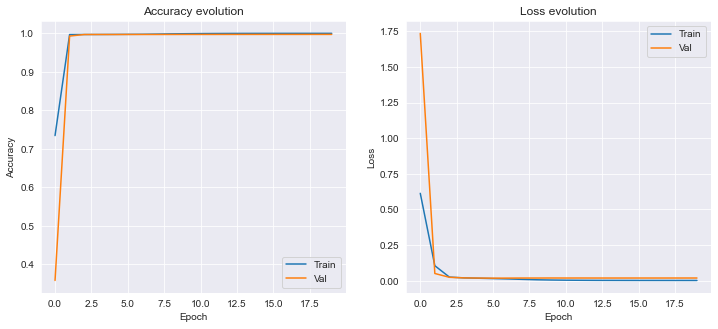

In [58]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])
plt.title('Accuracy evolution')

plt.subplot(122)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])
plt.title('Loss evolution');

In [ ]:
Model.save('FFN.h5')